In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def show_digit_image(data):
    """Show a digit as an image.
    
    Arguments
    data -- The image data.
    """
    fig, ax = plt.subplots()
    ax.imshow(data.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([]);

# The following code is a modification of the code found here:
# https://stackoverflow.com/questions/35651932/plotting-img-with-matplotlib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
def imscatter(x, y, images, cmap=plt.cm.gray_r, ax=None, zoom=1):
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, image in zip(x, y, images):
        im = OffsetImage(image, zoom=zoom, cmap=cmap, interpolation='nearest')
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

# The following code is a modification of the code found here:
# https://stackoverflow.com/questions/35651932/plotting-img-with-matplotlib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def imscatter(
    x,
    y,
    images,
    cmap=plt.cm.gray_r,
    ax=None,
    zoom=1
):
    """Do a scatter plot with images instead of points.
    
    Arguments
    x      -- The x coordinates.
    y      -- The y coordinates.
    images -- The images. Must be of shape (x.shape[0], d, d).
    
    Keyword Arguments
    cmap   -- A color map.
    ax     -- An axes object to plot on.
    zoom   -- How much to zoom.
    """
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, image in zip(x, y, images):
        im = OffsetImage(
            image,
            zoom=zoom,
            cmap=cmap,
            interpolation='nearest'
        )
        ab = AnnotationBbox(
            im,
            (x0, y0),
            xycoords='data',
            frameon=False
        )
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

# Clustering High-dimensional Data

We are going to cluster the MNIST dataset.
We cannot apply K-means directly to it because of its high dimensionality. If we did, we would get garbage.
Instead, we will first reduce the dimensionality of MNIST using PCA to two dimensions, and then we will apply K-means to the principal components.

In contrast to the previous hands-on activity, we will work with the entire training set and not just one digit.
So, we know there are 10 clusters (the digits from 0 to 9).
Let's see if our process identifies clusters corresponding to digits.
Here we go. First, download and load the MNIST data:

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X / 255.0

# Split data into train partition and test partition
np.random.seed(12345)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

/opt/homebrew/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Perfortm PCA on the entire data set keep two principal components:

In [3]:
from sklearn.decomposition import PCA

pca = PCA(
    n_components=2,
    whiten=True
).fit(x_train)

That's it. Let's now visualize the principal components:

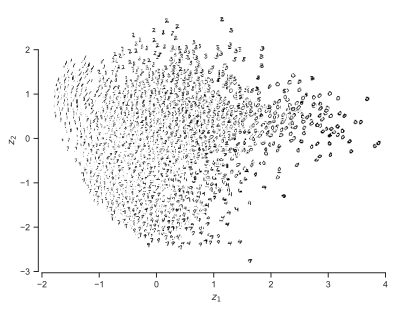

In [4]:
Z = pca.transform(x_train[:3000])

fig, ax = plt.subplots()
imscatter(
    Z[:, 0],
    Z[:, 1],
    x_train[:3000].reshape((3000, 28, 28)),
    ax=ax,
    zoom=0.2
)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
sns.despine(trim=True);

You can observe that PCA somewhat separates the digits.
It's imperfect (and you can do better with non-linear dimensionality reduction techniques), but it will do for now.

Now it's time for K-means:

In [5]:
from sklearn.cluster import KMeans

cl = KMeans(n_clusters=10).fit(Z)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Let's visualize the clusters:

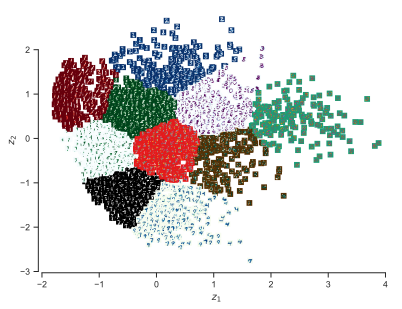

In [6]:
DIGIT_COLORS = [
    'Greys_r',
    'Blues_r',
    'BrBG',
    'BuGn',
    'BuPu',
    'Greens_r',
    'Dark2',
    'GnBu',
    'Reds_r',
    'Set1',
    'Spectral'
]

fig, ax = plt.subplots()
for i, c in enumerate(DIGIT_COLORS):
    idx = cl.labels_[:3000] == i
    imscatter(
        Z[:3000][idx, 0],
        Z[:3000][idx, 1],
        x_train[:3000][idx].reshape((sum(idx), 28, 28)),
        cmap=c,
        ax=ax,
        zoom=0.2
    )
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
sns.despine(trim=True);

This is nice! Observe that the clusters look very reasonable.
Again, they could be better, but they make sense.
The errors are pretty good, even in the cases we know are not classified correctly. The results are quite impressive if one considers that the algorithm we have put together does not know what digits are.

Okay. Let's look at the cluster centers more closely.
Let's visualize them as images.

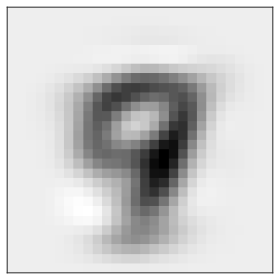

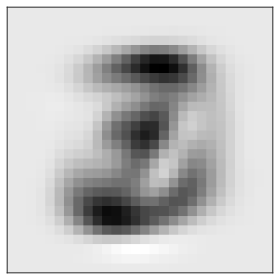

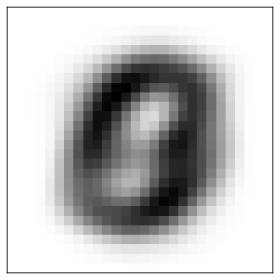

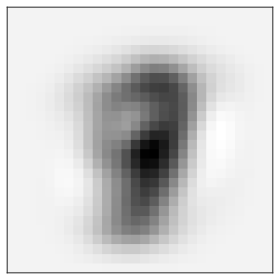

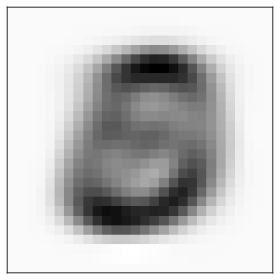

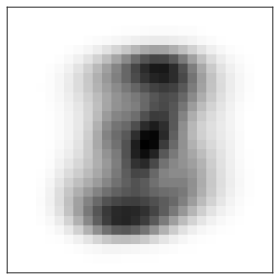

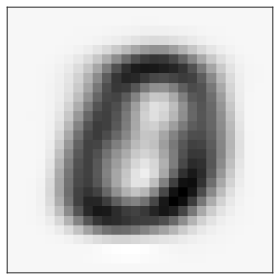

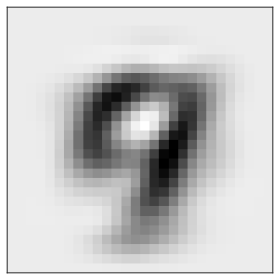

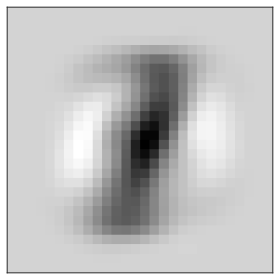

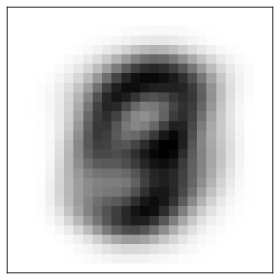

In [7]:
for i in range(10):
    show_digit_image(
        pca.inverse_transform(
            cl.cluster_centers_[i:(i+1), :]
        )
    )

## Questions

+ Which cluster centers are digits, and which aren't digits? Pick one of the non-digist clusters and figure out where it is. You can do this by looking at ``cl.centers_`` to identify the coordinates of the center. Why was it picked? Does its shape make sense now?

+ Repeat the above analysis using three principal components (instead of 2). (Note that the 2D visualization of the principal components will not make much sense now, so take it with a grain of salt.) Pay special attention to the identified cluster centers as images. Better or worse than before?

+ Repeat the analysis with five principal components.

+ Repeat the analysis with 200 principal components.